# Install libraries 

In [1]:
!pip3 install box2d-py
!pip3 install gym[Box_2D]
import gym
env = gym.make("CartPole-v1")

  Using cached box2d-py-2.3.8.tar.gz (374 kB)
  Running setup.py clean for box2d-py
Failed to build box2d-py
    Running setup.py install for box2d-py: started
    Running setup.py install for box2d-py: finished with status 'error'


  ERROR: Command errored out with exit status 1:
   command: 'C:\Users\Karim BOUKADIDA\anaconda3\python.exe' -u -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'C:\\Users\\Karim BOUKADIDA\\AppData\\Local\\Temp\\pip-install-mk8c9oif\\box2d-py_ae3a6f8973bc474daab159a07c23116d\\setup.py'"'"'; __file__='"'"'C:\\Users\\Karim BOUKADIDA\\AppData\\Local\\Temp\\pip-install-mk8c9oif\\box2d-py_ae3a6f8973bc474daab159a07c23116d\\setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' bdist_wheel -d 'C:\Users\Karim BOUKADIDA\AppData\Local\Temp\pip-wheel-xu0e9xwo'
       cwd: C:\Users\Karim BOUKADIDA\AppData\Local\Temp\pip-install-mk8c9oif\box2d-py_ae3a6f8973bc474daab159a07c23116d\
  Complete output (16 lines):
  Using setuptools (version 52.0.0.post20210125).
  running bdist_wheel
  running build
  running build_py
  creating build
  creating build\lib.win-amd64-3.8
  creati

In [2]:
!pip install pyglet

# Model and training

C:\Users\Karim BOUKADIDA\anaconda3\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


episode: 0/100, score: 20.0
episode: 1/100, score: 16.0
episode: 2/100, score: 15.0
episode: 3/100, score: 53.0
episode: 4/100, score: 19.0
episode: 5/100, score: 23.0
episode: 6/100, score: 20.0
episode: 7/100, score: 9.0
episode: 8/100, score: 14.0
episode: 9/100, score: 13.0
episode: 10/100, score: 12.0
episode: 11/100, score: 15.0
episode: 12/100, score: 12.0
episode: 13/100, score: 14.0
episode: 14/100, score: 15.0
episode: 15/100, score: 10.0
episode: 16/100, score: 9.0
episode: 17/100, score: 16.0
episode: 18/100, score: 17.0
episode: 19/100, score: 11.0
episode: 20/100, score: 9.0
episode: 21/100, score: 16.0
episode: 22/100, score: 14.0
episode: 23/100, score: 15.0
episode: 24/100, score: 16.0
episode: 25/100, score: 13.0
episode: 26/100, score: 22.0
episode: 27/100, score: 30.0
episode: 28/100, score: 60.0
episode: 29/100, score: 19.0
episode: 30/100, score: 60.0
episode: 31/100, score: 25.0
episode: 32/100, score: 46.0
episode: 33/100, score: 67.0
episode: 34/100, score: 81.

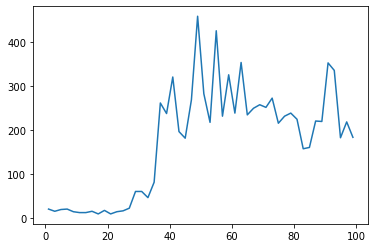

In [3]:
import random
# Keras for building the model
from keras import Sequential
# use the deque to save the results after every episode
from collections import deque
from keras.layers import Dense
#optimizer 
from tensorflow.keras.optimizers import Adam
# for the graph
import matplotlib.pyplot as plt
# Activations layers
from keras.activations import relu, linear

import numpy as np
env.seed(110)
np.random.seed(10)


class DQN:

    """ Implementation of deep q learning algorithm """
    # intialize the hyperparameters
    def __init__(self, action_space, state_space):

        self.action_space = action_space
        self.state_space = state_space
        self.epsilon = 1
        self.gamma = .95
        self.batch_size = 64
        self.epsilon_min = .01
        self.epsilon_decay = .995
        self.learning_rate = 0.001
        self.memory = deque(maxlen=10000)
        self.model = self.build_model()
    
    # building the model with the 3 layers(2 activations layers and the output layer)
    def build_model(self):
    
        model = Sequential()
        model.add(Dense(24, input_shape=(self.state_space,), activation='relu'))
        model.add(Dense(24, activation='relu'))
        model.add(Dense(self.action_space, activation='linear'))
        model.compile(loss='mse', optimizer=Adam(lr=self.learning_rate))
        return model
    # To save the actual_state, action , reward , next state in a deque for the replay buffer 
    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):

        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_space)
        act_values = self.model.predict(state)
        return np.argmax(act_values[0])

    def replay(self):

        if len(self.memory) < self.batch_size:
            return

        minibatch = random.sample(self.memory, self.batch_size)
        states = np.array([i[0] for i in minibatch])
        actions = np.array([i[1] for i in minibatch])
        rewards = np.array([i[2] for i in minibatch])
        next_states = np.array([i[3] for i in minibatch])
        dones = np.array([i[4] for i in minibatch])

        states = np.squeeze(states)
        next_states = np.squeeze(next_states)

        targets = rewards + self.gamma*(np.amax(self.model.predict_on_batch(next_states), axis=1))*(1-dones)
        targets_full = self.model.predict_on_batch(states)

        ind = np.array([i for i in range(self.batch_size)])
        targets_full[[ind], [actions]] = targets

        self.model.fit(states, targets_full, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay


def train_dqn(episode):

    loss = []
    agent = DQN(env.action_space.n, env.observation_space.shape[0])
    for e in range(episode):
        state = env.reset()
        state = np.reshape(state, (1, 4))
        score = 0
        max_steps = 1000
        for i in range(max_steps):
            env.render()
            action = agent.act(state)
            next_state, reward, done, _ = env.step(action)
            score += reward
            next_state = np.reshape(next_state, (1, 4))
            agent.remember(state, action, reward, next_state, done)
            state = next_state
            agent.replay()
            if done:
                print("episode: {}/{}, score: {}".format(e, episode, score))
                break
        loss.append(score)
    return loss


def random_policy(episode, step):

    for i_episode in range(episode):
        env.reset()
        for t in range(step):
            env.render()
            action = env.action_space.sample()
            state, reward, done, info = env.step(action)
            if done:
                print("Episode finished after {} timesteps".format(t+1))
                break
            print("Starting next episode")


if __name__ == '__main__':

    ep = 100
    loss = train_dqn(ep)
    plt.plot([i+1 for i in range(0, ep, 2)], loss[::2])
    plt.show()